In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df = pd.read_csv("datasets/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [5]:
df.info()

# TotalCharges object olmamalı.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Tip dönüşümü
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [7]:
df.shape

(7043, 21)

In [8]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [11]:
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

# Görev 1: Keşifci Veri Analizi

## Adım 1:

* Genel resmi inceleyiniz.

In [14]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0  7590-VHVEG  Female              0     Yes         No       1    

## Adım 2:

* Numerik ve kategorik değişkenleri yakalayınız.

In [17]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

print("#"*15)
print("cat_cols:", cat_cols)
print("#"*15)
print("num_cols:", num_cols)
print("#"*15)
print("cat_but_car:", cat_but_car)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2
###############
cat_cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn']
###############
num_cols: ['tenure', 'MonthlyCharges', 'TotalCharges']
###############
cat_but_car: ['customerID']


## Adım 3:

* Numerik ve kategorik değişkenlerin analizini yapınız.

In [18]:
# Kategorik değişkenlerin analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

        gender  Ratio
Male      3555 50.476
Female    3488 49.524
##########################################
     Partner  Ratio
No      3641 51.697
Yes     3402 48.303
##########################################
     Dependents  Ratio
No         4933 70.041
Yes        2110 29.959
##########################################
     PhoneService  Ratio
Yes          6361 90.317
No            682  9.683
##########################################
                  MultipleLines  Ratio
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################
             InternetService  Ratio
Fiber optic             3096 43.959
DSL                     2421 34.375
No                      1526 21.667
##########################################
                     OnlineSecurity  Ratio
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667


count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


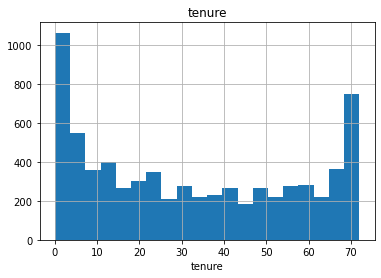

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


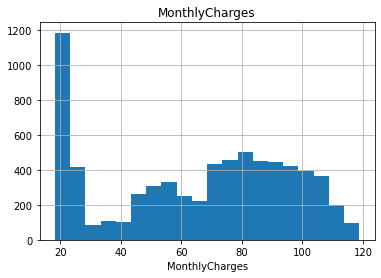

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


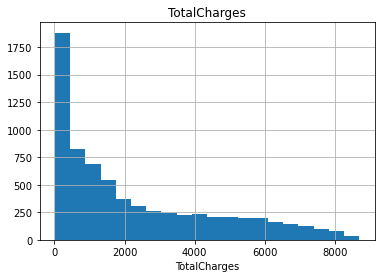

In [19]:
# Nümerik değişkenlerin analizi

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


for col in num_cols:
    num_summary(df, col, plot=True)

* tenure yani müşterilerin şirkette kaldığı ay sayısını incelediğimizde şirketin yeni müşteriler kazandığı görülüyor. 
* En çok 1 aylık müşteri var. Ardından ise 72 aylık müşteriler geliyor. 

In [20]:
# tenure acaba Contract tipine bağlı olabilir mi?
df.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

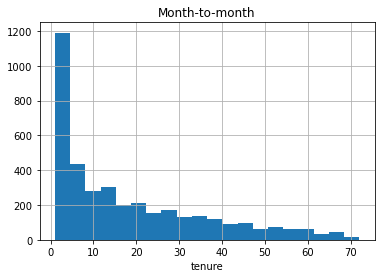

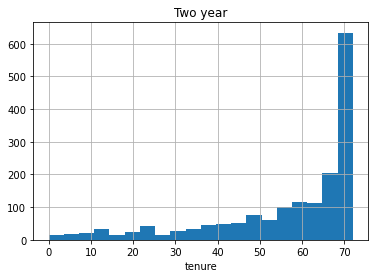

In [21]:
df[df["Contract"] == "Month-to-month"]["tenure"].hist(bins=20)
plt.xlabel("tenure")
plt.title("Month-to-month")
plt.show()

df[df["Contract"] == "Two year"]["tenure"].hist(bins=20)
plt.xlabel("tenure")
plt.title("Two year")
plt.show()

* Yeni gelip, aylık kontrat imzalayan müşteri sayısı oldukça fazla. 
* Aylık kontrat imzalayan müşteriler kalıcı olmuyor diyebilir miyiz? 
* 2 senelik kontrat imzalayan müşteri sayısı da fazla. 

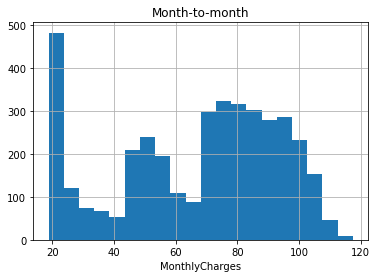

In [22]:
# MonthyChargers'a bakıldığında aylık sözleşmesi olan müşterilerin aylık ortalama ödemeleri daha fazla olabilir.
df[df["Contract"] == "Month-to-month"]["MonthlyCharges"].hist(bins=20)
plt.xlabel("MonthlyCharges")
plt.title("Month-to-month")
plt.show()


In [23]:
# Aylık konrat imzalayan müşteriler ortalama ne kadar ödüyor?
df[df["Contract"] == "Month-to-month"]["MonthlyCharges"].mean()

66.39849032258037

In [25]:
df[df["Contract"] == "Two year"]["MonthlyCharges"].mean()

60.770412979351

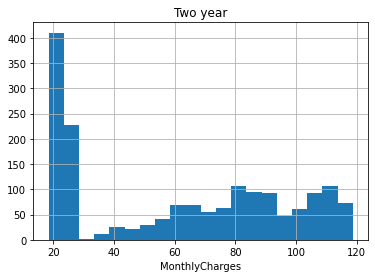

In [27]:
df[df["Contract"] == "Two year"]["MonthlyCharges"].hist(bins=20)
plt.xlabel("MonthlyCharges")
plt.title("Two year")
plt.show()

In [26]:
df[df["Contract"] == "One year"]["MonthlyCharges"].mean()

65.04860828241674

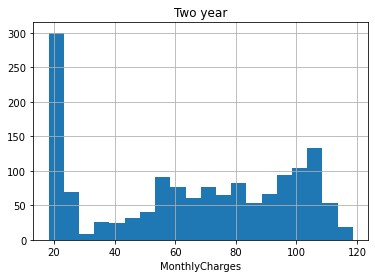

In [28]:
df[df["Contract"] == "One year"]["MonthlyCharges"].hist(bins=20)
plt.xlabel("MonthlyCharges")
plt.title("Two year")
plt.show()

## Adım 4:

* Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)

In [29]:
# Nümerik değişkenlerin target değişkene göre analizi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




In [30]:
# Kategorik değişkenlerin target'a göre analizi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count  Ratio
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
     TARGET_MEAN  Count  Ratio
No         0.330   3641 51.697
Yes        0.197   3402 48.303


Dependents
     TARGET_MEAN  Count  Ratio
No         0.313   4933 70.041
Yes        0.155   2110 29.959


PhoneService
     TARGET_MEAN  Count  Ratio
No         0.249    682  9.683
Yes        0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


InternetService
             TARGET_MEAN  Count  Ratio
DSL                0.190   2421 34.375
Fiber optic        0.419   3096 43.959
No                 0.074   1526 21.667


OnlineSecurity
                     TARGET_MEAN  Count  Ratio
No                         0.418   3498 49.666
No internet service        0.074   1526 21.667
Yes                        0.146   2019 28.667


O

## Adım 5:

* Aykırı gözlem analizi yapınız.

In [39]:
# Sınırların belirlenmesi
def outlier_thresholds(dataframe, col_name, q1_th=0.05, q3_th=0.95):
    quartile1 = dataframe[col_name].quantile(q1_th)
    quartile3 = dataframe[col_name].quantile(q3_th)
    inter_quantile_range = quartile3 - quartile1
    upper_limit = quartile3 + (1.5 * inter_quantile_range)
    lower_limit = quartile1 - (1.5 * inter_quantile_range)
    return lower_limit, upper_limit

In [40]:
# Aykırı değer var mı yok mu fonksiyonu

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    filter1 = (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
    return dataframe[filter1].any(axis=None) # True/False --> Outlier Var mı? Yok mu?

In [41]:
# Outlier yok

for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


## Adım 6:

* Eksik gözlem analizi yapınız.

In [42]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in df.columns if df[col].isnull().sum() > 0] # NaN değere sahip değişken isimleri
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False) # NaN değişken sayıları azalan
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0]*100).sort_values(ascending=False) # NaN değerlerin oranı
    missing_df = pd.concat([n_miss,  np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    
    if na_name: # Eksik değerlerin isimleri gelsin mi?
        return na_columns

missing_values_table(df)

              n_miss  ratio
TotalCharges      11  0.160


## Adım 7:

* Korelasyon analizi yapınız.

In [44]:
df[num_cols].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.826
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.826,0.651,1.000


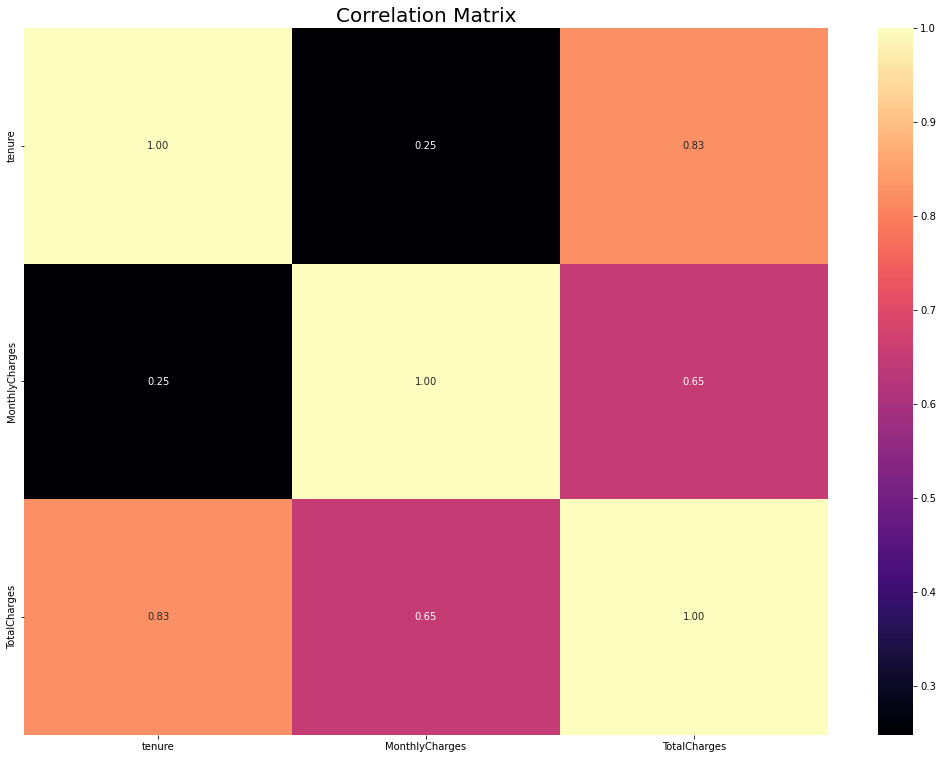

In [45]:
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

* TotalChargers ile "MonthlyCharges" ve "tenure" arasında kısmen yüksek korelasyon olduğu söylenebilir. 

# Görev 2: Feature Engineering

## Adım 1:

* Eksik ve aykırı gözlemler için gerekli işlemleri yapınız.

In [46]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [47]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

# eksik değer içeren kolonlar
na_columns = missing_values_table(df, na_name=True)
na_columns

              n_miss  ratio
TotalCharges      11  0.160


['TotalCharges']

In [51]:
# Eksik değerleri median ile dolduruyorum.
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

df.isnull().sum().sum()

0

In [52]:
# Sınırların belirlenmesi
def outlier_thresholds(dataframe, col_name, q1_th=0.05, q3_th=0.95):
    quartile1 = dataframe[col_name].quantile(q1_th)
    quartile3 = dataframe[col_name].quantile(q3_th)
    inter_quantile_range = quartile3 - quartile1
    upper_limit = quartile3 + (1.5 * inter_quantile_range)
    lower_limit = quartile1 - (1.5 * inter_quantile_range)
    return lower_limit, upper_limit

In [53]:
# Aykırı değer var mı yok mu fonksiyonu

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    filter1 = (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
    return dataframe[filter1].any(axis=None) # True/False --> Outlier Var mı? Yok mu?

In [54]:
# Outlier yok

for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


## Adım 2:

* Yeni değişkenler oluşturunuz.

In [55]:
# Tenure  değişkeninden yıllık kategorik değişken oluşturma
# Müşterinin kaç yıllık olduğunu içeren yeni bir kolon oluşturuyorum.

df.loc[(df["tenure"] >= 0) & (df["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"] > 12) & (df["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"] > 24) & (df["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"] > 36) & (df["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"] > 48) & (df["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"] > 60) & (df["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

In [59]:
# Aylık müşterilerin "Churn" çok oranı daha fazla
df.groupby("Contract").agg({"Churn":["mean", "count"]})

Churn      
                mean count
Contract                  
Month-to-month 0.427  3875
One year       0.113  1473
Two year       0.028  1695

In [56]:
# Kontratı 1 veya 2 yıllık müşterileri Engaged olarak belirtme
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

In [62]:
df.groupby("NEW_Engaged").agg({"Churn":"mean"})

,Churn
NEW_Engaged,
0,0.427
1,0.068


In [60]:
# Herhangi bir destek, yedek veya koruma almayan kişiler
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [66]:
df.groupby("NEW_noProt").agg({"Churn":"mean"})

,Churn
NEW_noProt,
0,0.088
1,0.286


In [64]:
# Aylık sözleşmesi bulunan ve genç olan müşteriler
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [65]:
df.groupby("NEW_Young_Not_Engaged").agg({"Churn":"mean"})

,Churn
NEW_Young_Not_Engaged,
0,0.165
1,0.396


In [67]:
# Kişinin toplam aldığı servis sayısı

# Aldıkları servis sayısını bir aralık olarak tutabilirdik..
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                               'OnlineBackup', 'DeviceProtection', 'TechSupport',
                               'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

In [68]:
df.groupby("NEW_TotalServices").agg({"Churn":"mean"})

,Churn
NEW_TotalServices,
0,0.438
1,0.217
2,0.435
3,0.347
4,0.272
5,0.220
6,0.126
7,0.058


In [69]:
# Herhangi bir streaming hizmeti alan kişiler
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [70]:
df.groupby("NEW_FLAG_ANY_STREAMING").agg({"Churn":"mean"})

,Churn
NEW_FLAG_ANY_STREAMING,
0,0.228
1,0.303


In [71]:
# Kişi otomatik ödeme yapıyor mu?
df["PaymentMethod"].unique()
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

In [72]:
df.groupby("NEW_FLAG_AutoPayment").agg({"Churn":"mean"})

,Churn
NEW_FLAG_AutoPayment,
0,0.347
1,0.160


In [73]:
# ortalama aylık ödeme
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] +0.1)

In [74]:
# Güncel Fiyatın ortalama fiyata göre artışı
df["NEW_Increase"] = df["NEW_AVG_Charges"] / (df["MonthlyCharges"] + 1)

In [75]:
# Servis başına ücret
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [76]:
df.shape

(7043, 31)

In [77]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,27.136,0.880,14.925
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,55.411,0.956,14.238
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,51.500,0.939,13.463
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.815,0.943,10.575
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,72.214,1.007,35.350


## Adım 3:

* Encoding işlemlerini gerçekleştiriniz.

In [78]:
# Yeni kolonlar ekledik. Tekrar değişkenleri yakalamalıyız.

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 8


In [79]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'Churn',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [80]:
num_cols

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'NEW_AVG_Charges',
 'NEW_Increase',
 'NEW_AVG_Service_Fee']

In [81]:
cat_but_car

['customerID']

In [82]:
# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

# Object ve 2 sınıfı olan değişkenler
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

In [88]:
# One-Hot Encoding İşlemi
# cat_cols listesinin güncelleme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [90]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.shape

(7043, 46)

## Adım 4:

* Numerik değişkenler için standartlaştırma yapınız.

In [91]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,1,0,1,0,1,29.850,29.850,0,1,27.136,0.880,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
1,5575-GNVDE,1,0,0,34,1,0,56.950,1889.500,0,3,55.411,0.956,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
2,3668-QPYBK,1,0,0,2,1,1,53.850,108.150,1,3,51.500,0.939,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,1,0,0,45,0,0,42.300,1840.750,0,3,40.815,0.943,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
4,9237-HQITU,0,0,0,2,1,1,70.700,151.650,1,1,72.214,1.007,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0


In [97]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])

## Adım 5:

* Model oluşturunuz.

In [98]:
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [99]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.66
Precision: 0.51
F1: 0.57
Auc: 0.74


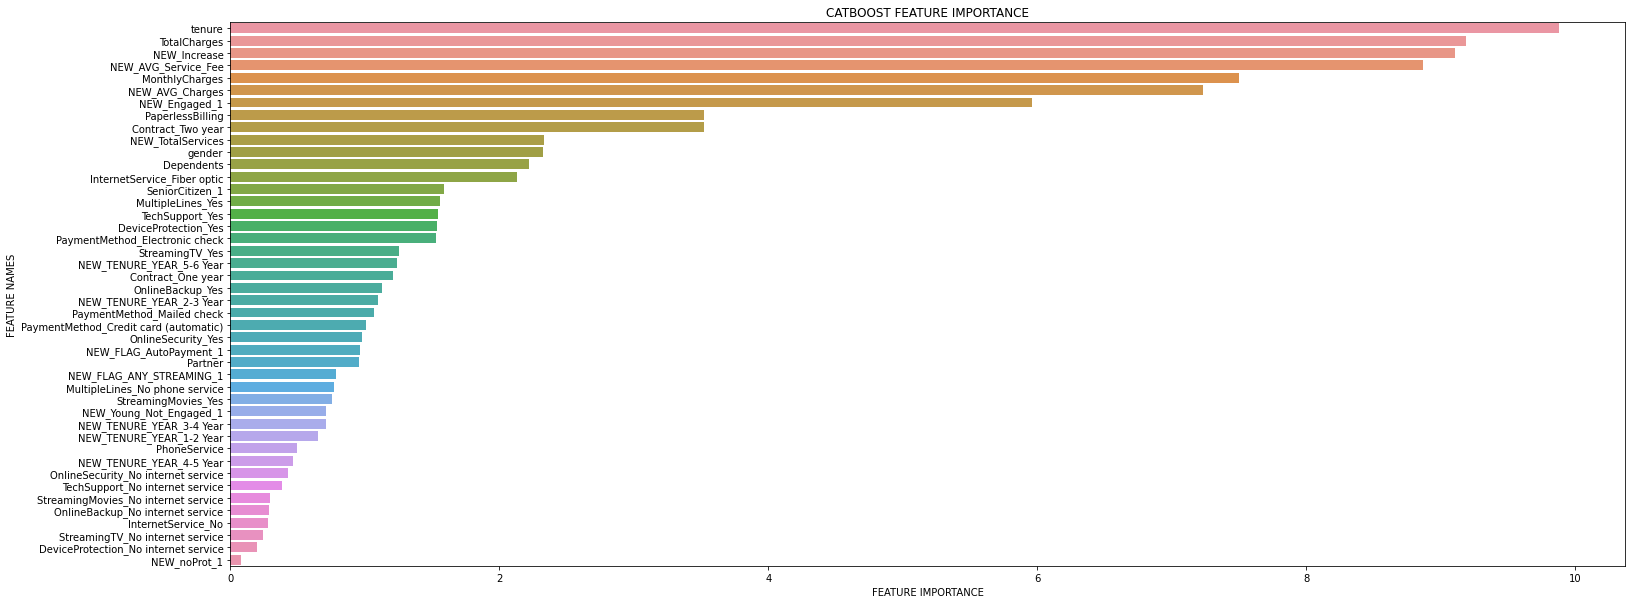

In [100]:
def plot_feature_importance(importance,names,model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(25, 10))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()


plot_feature_importance(catboost_model.get_feature_importance(), X.columns, 'CATBOOST')